In [2]:
import os
from datetime import datetime

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

from scipy.sparse import lil_matrix

import geopandas as gpd
from geopandas.tools import sjoin
import geoplot as gplt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

from util import *

# Data Loading

In [3]:
%%time
location_data=DataFrame()
loaded_files = []
for filename in os.listdir("data/locations"):
    if filename.endswith(".csv"):
        loaded_files.append(pd.read_csv("data/locations/"+filename))
location_data = pd.concat(loaded_files)

detail_data=DataFrame()
loaded_files = []
for filename in os.listdir("data/details"):
    if filename.endswith(".csv"):
        loaded_files.append(pd.read_csv("data/details/"+filename))
detail_data = pd.concat(loaded_files)
detail_data.reset_index(drop=True,inplace=True)

<string>:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
<string>:2: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 26.4 s


In [4]:
location_data['YEAR'] = (location_data.YEARMONTH-location_data.YEARMONTH%100)//100
location_data['MONTH'] = location_data.YEARMONTH%100
location_data = location_data.drop(['YEARMONTH', "LAT2", "LON2"], axis=1)

In [5]:
location_data.head()

,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,YEAR,MONTH
0,2030059,5548852,1,NaN,NaN,LANGLEY,34.32,-93.83,1996,3
1,2030060,5548853,1,2.0,S,YELLVILLE,36.20,-92.68,1996,3
2,1002564,5548854,1,NaN,NaN,COTTER,36.27,-92.53,1996,3
3,2030061,5548855,1,NaN,NaN,COTTER,36.27,-92.53,1996,3
4,2030062,5548856,1,5.0,WSW,MOUNTAIN HOME,36.30,-92.47,1996,3


In [6]:
detail_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,40.0,...,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB
1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,48.0,...,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB
2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB
3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB
4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB


# Convert the Time related strings to a DateTime column

In [7]:
%%time
# Pad the "DAY" columns to length 2 so the date parser can do it's thing
detail_data.BEGIN_DAY = detail_data.BEGIN_DAY.map(str).str.pad(2,fillchar='0')
detail_data.END_DAY = detail_data.END_DAY.map(str).str.pad(2,fillchar='0')
# ditto with the Time, except we're padding to the right this time
detail_data.BEGIN_TIME = detail_data.BEGIN_TIME.map(str).str.pad(4,side="right",fillchar='0')
detail_data.END_TIME = detail_data.END_TIME.map(str).str.pad(4,side="right",fillchar='0')
# create a new column by concating the three date/time related columns and convert the result to a datetime
detail_data['BEGIN_DATE']=detail_data.BEGIN_YEARMONTH.map(str)+" "+detail_data.BEGIN_DAY.map(str)+" "+detail_data.BEGIN_TIME.map(str)
detail_data.BEGIN_DATE=pd.to_datetime(detail_data.BEGIN_DATE, format='%Y%m %d %H%M', errors='coerce')

detail_data['END_DATE']=detail_data.END_YEARMONTH.map(str)+" "+detail_data.END_DAY.map(str)+" "+detail_data.END_TIME.map(str)
detail_data.END_DATE=pd.to_datetime(detail_data.END_DATE, format='%Y%m %d %H%M', errors='coerce')

# drop the old columns
detail_data = detail_data.drop(['BEGIN_YEARMONTH', "END_YEARMONTH",'BEGIN_DAY', "END_DAY", "BEGIN_TIME", "END_TIME"], axis=1)
detail_data = detail_data.drop(['YEAR', "MONTH_NAME",'END_DATE_TIME', "BEGIN_DATE_TIME"], axis=1)

# Columns I don't think I need at the momment
detail_data = detail_data.drop(['WFO', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'], axis=1)

Wall time: 26.7 s


# Correcting input errors
There's some input errors with the Lat/Long coordinates - decimal place is just shifted, so dividing those by ten gives us the correct value (Affects 2080 rows)

In [8]:
detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']=detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']/10
detail_data.loc[detail_data.END_LON < -180, 'END_LON']=detail_data.loc[detail_data.END_LON < -180, 'END_LON']/10

Fix inconsistencies in event type tagging

In [9]:
detail_data.loc[detail_data.EVENT_TYPE.isin(['HAIL FLOODING', 'HAIL/ICY ROADS']), 'EVENT_TYPE'] = 'Hail'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Heavy Wind']), 'EVENT_TYPE'] = 'High Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'TORNADOES, TSTM WIND, HAIL',
        'THUNDERSTORM WINDS/FLOODING',
        'THUNDERSTORM WINDS/FLASH FLOOD',
        'THUNDERSTORM WINDS LIGHTNING',
        'THUNDERSTORM WIND/ TREES',
        'THUNDERSTORM WIND/ TREE',
        'THUNDERSTORM WINDS FUNNEL CLOU',
        'THUNDERSTORM WINDS/HEAVY RAIN',
        'THUNDERSTORM WINDS HEAVY RAIN',
        'THUNDERSTORM WINDS/ FLOOD'
    ]
), 'EVENT_TYPE'] = 'Thunderstorm Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['TORNADO/WATERSPOUT']), 'EVENT_TYPE'] = 'Tornado'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Landslide']), 'EVENT_TYPE'] = 'Debris Flow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Volcanic Ashfall']), 'EVENT_TYPE'] = 'Volcanic Ash'

Drop 14 rows tagged "Northern Lights" and a single row tagged 'OTHER'.

In [10]:
detail_data.drop(detail_data[detail_data.EVENT_TYPE.isin(['Northern Lights', 'OTHER'])].index, inplace=True)

# Create Categorical Index

Create two categories - one based off of the event type and another based on my not very scientific classification

In [11]:
detail_data.EVENT_TYPE = detail_data.EVENT_TYPE.astype("category")
detail_data['EVENT_CODE'] = detail_data.EVENT_TYPE.cat.codes

In [12]:
detail_data['META_TYPE'] = None
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Avalanche',
        'Blizzard',
        'Cold/Wind Chill',
        'Extreme Cold/Wind Chill',
        'Freezing Fog',
        'Frost/Freeze',
        'Hail',
        'Heavy Snow',
        'Ice Storm',
        'Lake-Effect Snow',
        'Marine Hail',
        'Sleet',
        'Winter Storm',
        'Winter Weather'
    ]
), 'META_TYPE'] = 'Cold'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dense Smoke',
        'Drought',
        'Excessive Heat',
        'Heat',
        'Volcanic Ash',
        'Wildfire'
    ]
), 'META_TYPE'] = 'Heat'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Debris Flow',
        'Dense Fog',
        'Lightning',
        'Marine Dense Fog',
        'Marine Lightning'
    ]
), 'META_TYPE'] = 'Other'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Astronomical Low Tide',
        'Coastal Flood',
        'Flash Flood',
        'Flood',
        'Heavy Rain',
        'High Surf',
        'Lakeshore Flood',
        'Rip Current',
        'Seiche',
        'Sneakerwave',
        'Storm Surge/Tide',
        'Tsunami',
        'Waterspout'
    ]
), 'META_TYPE'] = 'Water'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dust Devil',
        'Dust Storm',
        'Funnel Cloud',
        'High Wind',
        'Hurricane',
        'Hurricane (Typhoon)',
        'Marine High Wind',
        'Marine Hurricane/Typhoon',
        'Marine Strong Wind',
        'Marine Thunderstorm Wind',
        'Marine Tropical Depression',
        'Marine Tropical Storm',
        'Strong Wind',
        'Thunderstorm Wind',
        'Tornado',
        'Tropical Depression',
        'Tropical Storm'
    ]
), 'META_TYPE'] = 'Wind'
detail_data.META_TYPE = detail_data.META_TYPE.astype("category")
detail_data['META_CODE'] = detail_data.META_TYPE.cat.codes

In [13]:
detail_data[detail_data.META_TYPE=='Heat'].sample()

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,CZ_TIMEZONE,INJURIES_DIRECT,...,DAMAGE_CROPS,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,BEGIN_DATE,END_DATE,EVENT_CODE,META_TYPE,META_CODE
1498085,127254.0,762770,TEXAS,48.0,Heat,Z,149,CHEROKEE,CST-6,0,...,0.00K,NaN,NaN,NaN,NaN,2018-07-13 11:00:00,2018-07-13 18:00:00,19,Heat,1


# Fill in missing geographic data
The US Census Gazetteer contains a file which provides Lat/Long for every county in the US. Combined with the FIPs codes, we can give estimated locations for events with no clear starting point (about 1/3 of the dataset - things like "drought" or "Strong Wind" that don't have a clearly defined geographic location).
Dataset from https://www.census.gov/geo/maps-data/data/gazetteer2017.html

In [14]:
county_df = pd.read_csv('data/2017_Gaz_counties_national.txt', sep='\t', engine='python')
county_df['GEOID'] = county_df['GEOID'].apply(lambda x: '{0:0>5}'.format(x))
county_df.set_index("GEOID", inplace=True)

In [15]:
county_df.head()

,USPS,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
GEOID,,,,,,,,,
01001,AL,161526,Autauga County,1539614693,25744269,594.449,9.940,32.532237,-86.646440
01003,AL,161527,Baldwin County,4117605847,1133109409,1589.817,437.496,30.659218,-87.746067
01005,AL,161528,Barbour County,2292144656,50538698,885.002,19.513,31.870253,-85.405104
01007,AL,161529,Bibb County,1612165763,9603798,622.461,3.708,33.015893,-87.127148
01009,AL,161530,Blount County,1670079465,15039864,644.821,5.807,33.977358,-86.566440


### Fill in Lat/Lon for events based on county centroid
Create a new column that combines the State and County FIPS so we can look them up

In [16]:
detail_data['FIPS'] = detail_data['STATE_FIPS']*1000+detail_data['CZ_FIPS']

Try to match up FIPS ids for events with no location info, and fill in the begin lat/lon with that counties centroid

In [ ]:
# iterate through the rows that are currently missing data and try to 
count = 0
total_count = len(detail_data[detail_data.BEGIN_LAT.isnull()])
for i, row in detail_data[detail_data.BEGIN_LAT.isnull()].iterrows():
    try:
        location = county_df.loc['{0:0>5}'.format(int(row.FIPS))]
        detail_data.loc[i,'BEGIN_LAT'] = location['INTPTLAT']
        detail_data.loc[i,'BEGIN_LON'] = location['INTPTLONG']
    except Exception as e:
        pass
    count +=1
    if count%1000 == 0:
        print('{} of {}'.format(count, total_count))

### Trim the data to just the Continental US

In [17]:
detail_data = detail_data[
        (detail_data.BEGIN_LON > -124.7844079) &
        (detail_data.BEGIN_LON < -66.9513812) &
        (detail_data.BEGIN_LAT > 24.7433195) &
        (detail_data.BEGIN_LAT < 49.3457868)
    ]

### TODO: look at filling in the remaining missing points with bp02oc18.dbx from https://www.weather.gov/gis/ZoneCounty

# Create the matricies and Plotting

In [35]:
def get_year_month_matrix(year, month):
    start = "{:0d}-{:02d}-01".format(year, month)
    if month == 12:
        month = 1
        year += 1
    else:
        month+=1
    end = "{:0d}-{:02d}-01".format(year, month)
    year_data = detail_data[(detail_data.BEGIN_DATE>start) & (detail_data.BEGIN_DATE<end)].dropna()
    # trim it to just the continental US
    year_data = year_data[
        (year_data.BEGIN_LON > -124.7844079) &
        (year_data.BEGIN_LON < -66.9513812) &
        (year_data.BEGIN_LAT > 24.7433195) &
        (year_data.BEGIN_LAT < 49.3457868)
    ]
    m = lil_matrix((5783,2760), dtype=np.int16)
    for i, row in year_data.iterrows():
        if row.END_LAT==np.nan or row.END_LON==np.nan:
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] = 1
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] = 1
                except:
                    print("bad row:",pos)
    return m



In [36]:
def create_geopandas_from_matrix(m):
    # get the row and col arrays from the non zero elements of the matrix
    row,col = m.nonzero()
    # iterate through the arrays and convert them to their lat/lon approximations
    data=[]
    for x in range(len(row)):
#         if index_to_lat(col[x]) > 50:
#             print(col[x],row[x])
        data.append({
            "lat":index_to_lat(col[x]),
            "lon":index_to_lon(row[x]),
            "x":1
        })
    # create a pandas dataframe from the data, then convert it to a geopandas dataframe
    data = DataFrame(data)
    data['Coordinates'] = list(zip(data.lon, data.lat))
    data['Coordinates'] = data['Coordinates'].apply(Point)
    return gpd.GeoDataFrame(data, geometry='Coordinates')

In [42]:
%%time
mats = [] 
for year in range(1996,2017):
    mats.append(get_year_month_matrix(year,4))

geo = []
for m in mats:
    geo.append(create_geopandas_from_matrix(m))
    
data = pd.concat(geo)

bad row: (2021, 5783)
bad row: (2020, 5783)
Wall time: 10.6 s


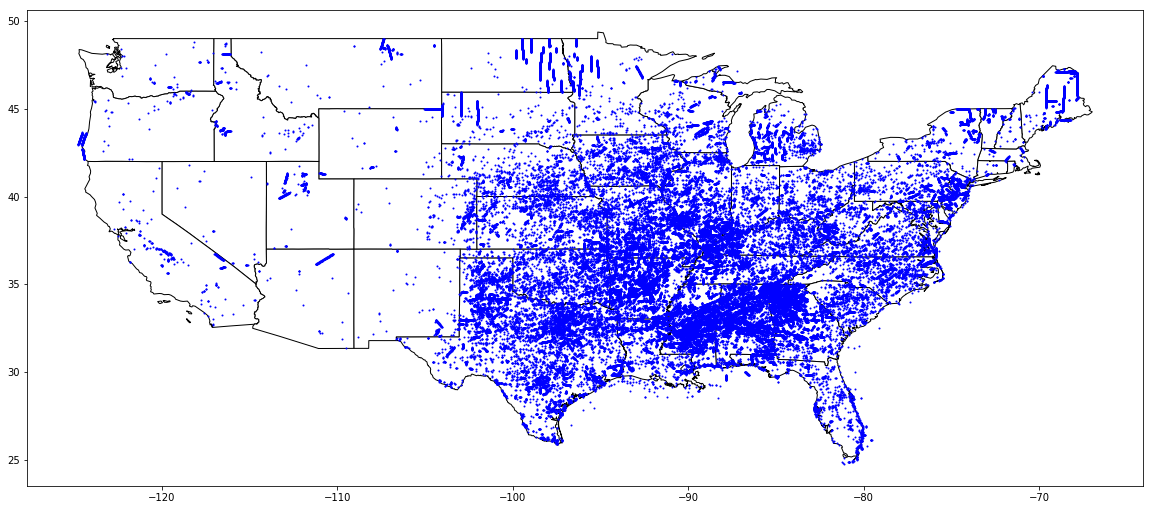

In [43]:
us_map = gpd.read_file("data/states_shape/states.shp")
ax = us_map[~us_map.STATE_NAME.isin(['Hawaii',"Alaska"])].plot(
    color='white', edgecolor='black', figsize=(20,20))

# We can now plot our GeoDataFrame.
data.plot(ax=ax, color='blue', markersize=1)

plt.show()

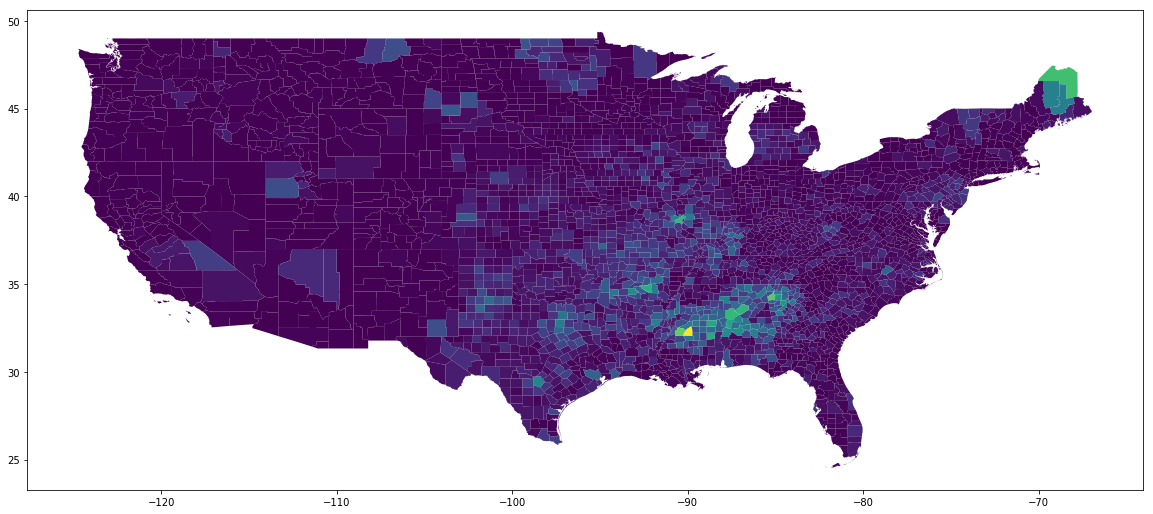

In [45]:
us_county_map = gpd.read_file("data/shape/us_counties/cb_2017_us_county_500k.shp")
us_county_map.STATEFP = us_county_map.STATEFP.astype(int)
# constrain the county map to the continental us
us_county_map = us_county_map[
    (us_county_map.STATEFP<60) &
    (us_county_map.STATEFP!=2) &
    (us_county_map.STATEFP!=15)
]

data.crs = us_county_map.crs
county_data = sjoin(data, us_county_map, how='left')
us_county_map.set_index("GEOID", inplace=True)
us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
us_county_map.counts.fillna(0, inplace=True)

ax = us_county_map.plot(column="counts", figsize=(20,20))

# We can now plot our GeoDataFrame.
plt.show()

In [47]:
import pysal

F:\Programs\Anaconda\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [51]:
%%time
wq = pysal.weights.Queen.from_dataframe(us_county_map)
wq.transform = 'r'

('WARNING: ', '53055', ' is an island (no neighbors)')
('WARNING: ', '25019', ' is an island (no neighbors)')
('WARNING: ', '25007', ' is an island (no neighbors)')
Wall time: 9.29 s


F:\Programs\Anaconda\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 3 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
F:\Programs\Anaconda\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 53055, 25019, 25007
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [53]:
y = us_county_map['counts']
ylag = pysal.weights.lag_spatial(wq,y)

array([ 59.625     , 128.57142857,  18.75      , ...,  18.14285714,
        35.28571429,  26.16666667])

In [56]:
import pysal.esda.mapclassify as mc

In [57]:
ylagq5 = mc.Quantiles(ylag, k=5)

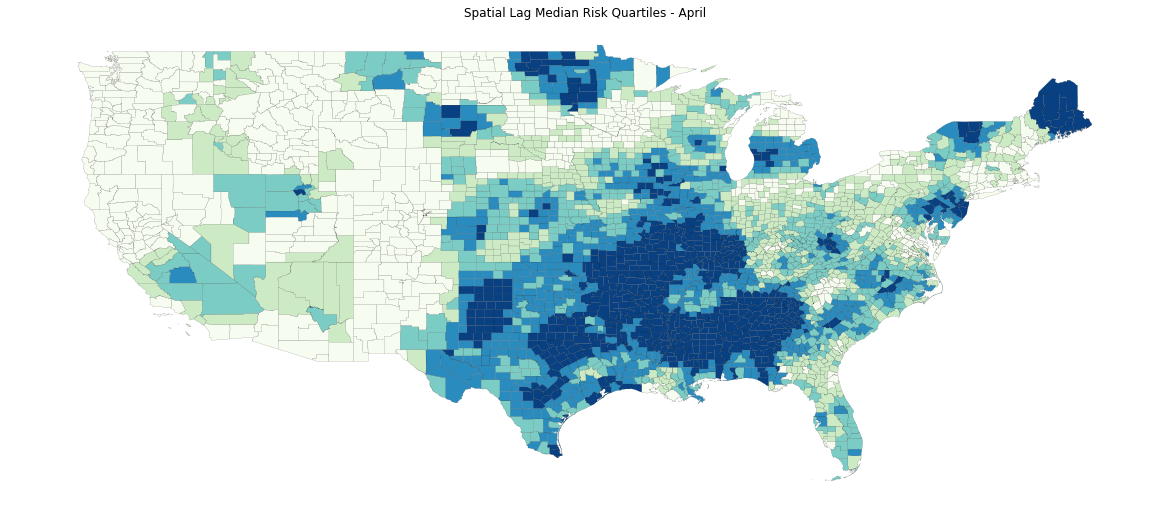

In [65]:
f, ax = plt.subplots(1, figsize=(20, 20))
us_county_map.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1, ax=ax,
        edgecolor='black')
ax.set_axis_off()
plt.title("Spatial Lag Median Risk Quartiles - April")
plt.show()

0.5843106105136605

Text(0.5,0,"Moran's I")

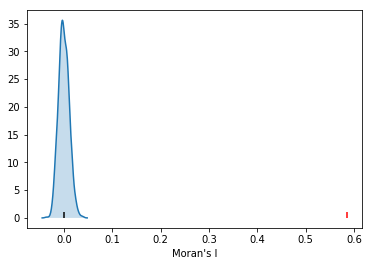

In [70]:
# https://en.wikipedia.org/wiki/Moran%27s_I
import pysal.esda as esda
import seaborn as sns

mi = esda.moran.Moran(y, wq)
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [72]:
li = esda.moran.Moran_Local(y, wq)

F:\Programs\Anaconda\lib\site-packages\pysal\esda\moran.py:861: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
F:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
F:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
F:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [74]:
(li.p_sim < 0.05).sum()

1060

In [80]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 0, ..., 0, 0, 0])

In [81]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

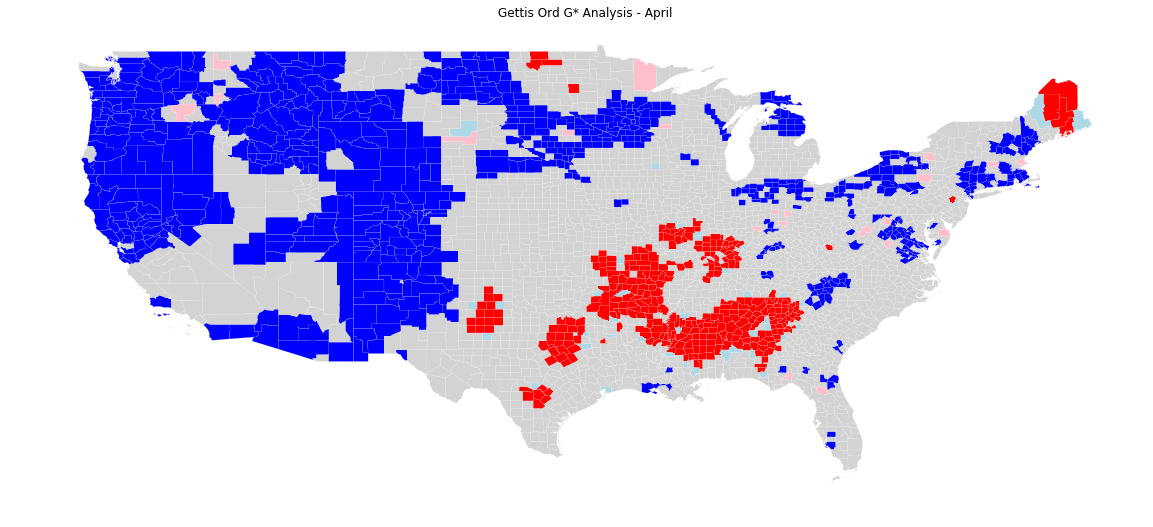

In [84]:
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(20, 10))
us_county_map.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white')
ax.set_axis_off()

plt.title("Gettis Ord G* Analysis - April")
plt.show()

In [61]:
us_county_map.sort_values("counts", ascending=False)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,counts
GEOID,,,,,,,,,,
28121,28,121,00695781,0500000US28121,Rankin,06,2008322209,79429951,"POLYGON ((-90.253456 32.152451, -90.2484209999...",459.0
28049,28,049,00695748,0500000US28049,Hinds,06,2252651371,19495790,"POLYGON ((-90.727881 32.226019, -90.7255019999...",349.0
13115,13,115,00353665,0500000US13115,Floyd,06,1320436485,22382107,"POLYGON ((-85.4620817189037 34.2863854944266, ...",342.0
23003,23,003,00581287,0500000US23003,Aroostook,06,17278038056,405253238,"POLYGON ((-70.019747 46.592166, -69.997086 46....",320.0
01125,1,125,00161588,0500000US01125,Tuscaloosa,06,3421041792,78682797,"POLYGON ((-87.840683 33.524839, -87.802088 33....",306.0
29189,29,189,00758549,0500000US29189,St. Louis,06,1314771903,39737787,"POLYGON ((-90.73643 38.469853, -90.73613999999...",305.0
01073,1,073,00161562,0500000US01073,Jefferson,06,2877921069,32756125,"POLYGON ((-87.33720000000001 33.475396, -87.33...",300.0
05119,5,119,00069177,0500000US05119,Pulaski,06,1965575733,126242806,"POLYGON ((-92.754975 34.878641, -92.7545179999...",288.0
28023,28,023,00695736,0500000US28023,Clarke,06,1791177222,5069761,"POLYGON ((-88.914277 32.195929, -88.9138469999...",283.0


In [55]:
p1 = Point(-74.56999999999999,41.85)

In [78]:
for i,county in us_county_map.iterrows():
    if county.geometry.contains(p1):
        print(county)

STATEFP                                                    36
COUNTYFP                                                  105
COUNTYNS                                             00974150
AFFGEOID                                       0500000US36105
GEOID                                                   36105
NAME                                                 Sullivan
LSAD                                                       06
ALAND                                              2507463254
AWATER                                               74035009
geometry    POLYGON ((-75.146446 41.850899, -75.0293279999...
Name: 464, dtype: object


# Make Predictions

In [77]:
us_county_map[us_county_map.NAME=="Sullivan"]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
464,36,105,00974150,0500000US36105,36105,Sullivan,06,2507463254,74035009,"POLYGON ((-75.146446 41.850899, -75.0293279999..."
805,47,163,01639793,0500000US47163,47163,Sullivan,06,1070732761,42201523,"POLYGON ((-82.70067899999999 36.456199, -82.69..."
2065,29,211,00758558,0500000US29211,29211,Sullivan,06,1678264466,9123184,"POLYGON ((-93.367295 40.324665, -93.3670729999..."
2466,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338399,6617028,"POLYGON ((-76.81373099999999 41.590034, -76.79..."
2567,33,019,00873183,0500000US33019,33019,Sullivan,06,1392157812,37865613,"POLYGON ((-72.452556 43.172117, -72.4514309167..."
2790,18,153,00450391,0500000US18153,18153,Sullivan,06,1158058307,18096342,"POLYGON ((-87.658745 39.135997, -87.653201 39...."


In [ ]:
def get_actual(lat, lon, month, search_range=.25):
    year = 2016
    start = "{:0d}-{:02d}-01".format(year, month)
    if month == 12:
        month = 1
        year += 1
    else:
        month+=1
    end = "{:0d}-{:02d}-01".format(year, month)
    threshold = 1/(search_range*search_range*100*100)/12
    event_count = len(detail_data[
        (detail_data.BEGIN_DATE>start) & 
        (detail_data.BEGIN_DATE<end) &
        (detail_data.BEGIN_LON > lon-search_range) &
        (detail_data.BEGIN_LON < lon+search_range) &
        (detail_data.BEGIN_LAT > lat-search_range) &
        (detail_data.BEGIN_LAT < lat+search_range)
    ])
    seen_per = event_count/(search_range*search_range*3*100*100)
    
    return seen_per>threshold, seen_per/threshold, seen_per


In [ ]:
def search(lat,long,month,search_range=25):
    col_center = lat_to_index(lat)
    row_center = lon_to_index(long)

    event_count = 0
    total_count = 0
    y = {}
    for year in range(1996,2015):
        m = mats[str(year)]["{:02d}".format(month)]
        y[year] = 0

        for col in range(col_center-search_range, col_center+search_range+1):
            for row in range(row_center-search_range, row_center+search_range+1):
                if row >= 0 and row <= 5782 and col >= 0 and col <= 2459:
                    total_count += 1
                    val = m[row,col]
                    if val > 0:
                        event_count += val
                        y[year] += val
                    
    count = 0
    for e in y.values():
        if e > 30:
            count += 1
    prob = min(count/len(d)*4,.99)
    
    return prob > 0.6, prob

In [ ]:
lat,long,month = 42.16,-83.44,7
print("Ann Arbor", search(lat,long,month), get_actual(lat,long,month))

In [ ]:
d = {1996: 0, 1997: 0, 1998: 0, 1999: 0, 2000: 0, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 219, 2008: 49, 2009: 0, 2010: 285, 2011: 756, 2012: 253, 2013: 139, 2014: 131}

In [ ]:
count = 0
for e in d.values():
    if e > 30:
        count += 1
count/len(d)

In [ ]:
import random
correct = 0
total = 0
pos = 0
for random_sample_row in detail_data[(detail_data.BEGIN_DATE>'2015-01-01') & (detail_data.BEGIN_DATE<'2016-01-01')].dropna().sample(5).iterrows():
    random_sample_row = random_sample_row[1]
    lat,lon = random_sample_row.BEGIN_LAT, random_sample_row.BEGIN_LON
    event_type = random_sample_row.EVENT_TYPE
    month = random.randint(1,12)
    
    prediction = search(lat,lon,month)
    actual = get_actual(lat,lon,month)
    
#     print("({}/{}-{}) {} - Prediction: {}, Actual: {}".format(lat,lon,month,event_type,prediction,actual))
    
    total += 1
    if prediction[0] == actual[0]:
        correct += 1
    if prediction[0]:
        pos += 1

print("total: {:2f}".format(correct/total*100))
print("positives:",pos)

In [ ]:
%%time
import random
correct = 0
total = 0
results = {"pos":0,"neg":0,"false_pos":0,"false_neg":0}
over_99 = {"pos":0,"neg":0}
for random_sample_row in detail_data[(detail_data.BEGIN_DATE>'2015-01-01') & (detail_data.BEGIN_DATE<'2016-01-01')].dropna().sample(5).iterrows():
    random_sample_row = random_sample_row[1]
    lat,lon = random_sample_row.BEGIN_LAT, random_sample_row.BEGIN_LON
    month = random.randint(1,12)
    
    prediction = search(lat,lon,month)
    actual = get_actual(lat,lon,month)
    
    print("({}/{}-{}) Prediction: {}, Actual: {}".format(lat,lon,month,prediction,actual))
    
    total += 1
    if prediction[0] == actual[0]:
        correct += 1
    
    if prediction[0] == True and actual[0] == True:
        results["pos"] += 1
    elif prediction[0] == False and actual[0] == False:
        results["neg"] += 1
    elif prediction[0] == True and actual[0] == False:
        results["false_pos"] += 1
    elif prediction[0] == False and actual[0] == True:
        results["false_neg"] += 1
        
    if prediction[1] == 0.99:
        if actual[0] == True:
            over_99['pos'] += 1
        else:
            over_99['neg'] += 1
        

print("total: {:2f}".format(correct/total*100))
print(results)
print(over_99)

In [ ]:
(122+244)/500
67/500

In [ ]:
lat,long,month = 40.71,-74.00,1
print("Chicago", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 42.21,71.03,3
print("Boston", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 42.16,-83.44,7
print("Ann Arbor", search(lat,long,month), get_actual(lat,long,month))


lat,long,month = 29.99,-91.07,2
print("Assumption, LA", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 34.73,-96.15,5
print("Caddo, OK", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 29.86,-95.39,5
print("Harris, TX", search(lat,long,month), get_actual(lat,long,month))


lat,long,month = 34.05,-118.25,6
print("Los Angeles", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 32.42, -117.09,7
print("San Diego", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 34.16, -118.44,11
print("Simi Valley", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 38.5, -104.494,7
print("Colorado Springs", search(lat,long,month), get_actual(lat,long,month))

In [ ]:
for month in range(1,13):
    lat,long = 34.05,-118.25
    print("Los Angeles", search(lat,long,month), get_actual(lat,long,month))